<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

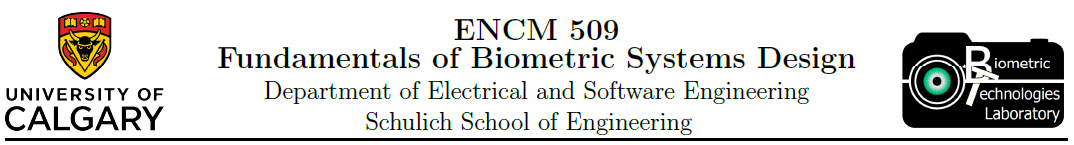

<center>
    <h1>Laboratory Experiment #7</h1>
    <h2>Gesture Identification Using Leap Motion and Deep Learning</h2>
    <h2>Talha Khalil, 30037871</h2>
</center>

## Introduction
The purpose of this lab is to apply machine learning concepts to recognize gestures. Classification is performed in python 3 using the Keras library, and the classifier that will be invistigated and used will the be the Long Short-term Memory (LSTM), which is a deep learning model for time-series analysis. For this specific lab the data is provided by the lab instructors.

In [73]:
# Supress pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath
from sklearn.metrics import confusion_matrix
from utils_cm import plot_confusion_matrix


In [74]:
# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 100
# the number of features (from the data)
NUMBER_FEATURES = 202
# the number of classes/gestures
NUMBER_OUTPUTS = 2
# you can encode more than 1 but for this example we have binary output (circle/swipe)

# the directory where your data is
mypath = './data'

# creating a list with all the filenames
datafiles = [f for f in listdir('data') if isfile(join(mypath, f))]

# choose data we need
columns = ['handPalmPosition_X','handPalmPosition_Y','handPalmPosition_Z',
          'pitch', 'roll', 'yaw', 'GestureTypeCircle', 'GestureTypeSwipe',
          'wristPosition_X', 'wristPosition_Y','wristPosition_Z',
          'elbowPosition_X', 'elbowPosition_Y', 'elbowPosition_Z']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
bone_names = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
    
for finger in finger_names:
    columns.append(finger + 'Length')
    columns.append(finger + 'Width')

for finger in finger_names:
    for bone in bone_names:
        columns.append(finger + bone + 'Start_X')
        columns.append(finger + bone + 'Start_Y')
        columns.append(finger + bone + 'Start_Z')
        columns.append(finger + bone + 'End_X')
        columns.append(finger + bone + 'End_Y')
        columns.append(finger + bone + 'End_Z')
        columns.append(finger + bone + 'Direction_X') 
        columns.append(finger + bone + 'Direction_Y') 
        columns.append(finger + bone + 'Direction_Z')   

# Features
x = []
# Labels
y = []

for sample in datafiles:
    relative_path = 'data\\' + sample
    tmp = pd.read_csv(relative_path, usecols=columns)
    
    # Normalize the sample size: LSTM requires all inputs of the same size!
    print('{}\nsize raw = {}'.format(relative_path,tmp.shape))
    while tmp.shape[0] < NUMBER_TIMESTEPS:
        tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)

    if tmp.shape[0] > NUMBER_TIMESTEPS:
        tmp = tmp.head(100)
    print('size normalized = ',tmp.shape)
    
    tmp_x = tmp[[column for column in list(tmp.columns)
                 if column != 'GestureTypeCircle' 
                 and column != 'GestureTypeSwipe']]
    tmp_y = tmp[['GestureTypeCircle', 'GestureTypeSwipe']]
        
    x.append(tmp_x)
    y.append(tmp_y)

np.array(y[0].loc[0])

# Each sample requires labels of [1,NUMBER_OUTPUTS] size (not a list)
y_new = list()
for cur_label in y:
    tmp = np.array(cur_label.loc[0])
    y_new.append(tmp)
y = np.array(y_new)


data\circle1.csv
size raw = (37, 204)
size normalized =  (100, 204)
data\circle10.csv
size raw = (60, 204)
size normalized =  (100, 204)
data\circle2.csv
size raw = (66, 204)
size normalized =  (100, 204)
data\circle3.csv
size raw = (39, 204)
size normalized =  (100, 204)
data\circle4.csv
size raw = (39, 204)
size normalized =  (100, 204)
data\circle5.csv
size raw = (78, 204)
size normalized =  (100, 204)
data\circle6.csv
size raw = (129, 204)
size normalized =  (100, 204)
data\circle7.csv
size raw = (80, 204)
size normalized =  (100, 204)
data\circle8.csv
size raw = (97, 204)
size normalized =  (100, 204)
data\circle9.csv
size raw = (67, 204)
size normalized =  (100, 204)
data\swipe1.csv
size raw = (84, 204)
size normalized =  (100, 204)
data\swipe10.csv
size raw = (84, 204)
size normalized =  (100, 204)
data\swipe2.csv
size raw = (39, 204)
size normalized =  (100, 204)
data\swipe3.csv
size raw = (62, 204)
size normalized =  (100, 204)
data\swipe4.csv
size raw = (59, 204)
size normali

In [75]:
def build_model(drop_out_probability: int = 0.5, three_inner_layers: bool = False, show_model_summary: bool = False):
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    if (three_inner_layers):
        # 2nd LSTM layer
        model.add(layers.LSTM(256, return_sequences=True,input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd/3rd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )

    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))  
    model.add(layers.Dropout(drop_out_probability))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(drop_out_probability))
    model.add(layers.Dense(512,activation='relu'))
    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    if (show_model_summary):
         model.summary()
    
    return model

def train_and_evaluate_model(testing_set_fraction: int = 0.30, drop_out_probability: int = 0.5, three_ltsm_layers:bool = False,show_model_summary: bool = False):
    # Set a percentage of test set fraction
    test_size = testing_set_fraction

    # Divide data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True)
    len_train = len(X_train)
    len_test = len(X_test)

    print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))
    # print ('There is ',type(X_train),' of ',type(X_train[0]))

    # Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    # print('The list was turned into <numpy.ndarray>')

    model = build_model(drop_out_probability,three_ltsm_layers, show_model_summary)
    # training the model
    model.fit(X_train, y_train, epochs=10, batch_size=len_train)
    # testing the model
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=len_train)

    y_pred = model.predict(X_test)
    matches = (y_pred == y_test)

    print('Total of matches: %d' % (matches.sum()))

    match_rate = matches.sum() / float(len(matches))
    print('Match rate: %.2f' % (match_rate))

    # Creating labels for covariance matrix

    t_labels = []
    for y_val in y_test:
        if (y_val[0] == 1):
            t_labels.append("Circle")
        elif (y_val[1] == 1):
            t_labels.append("Swipe")
        else:
            t_labels.append("None")
    
    p_labels = []
    for y_val in y_pred:
        if (y_val[0] == 1):
            p_labels.append("Circle")
        elif (y_val[1] == 1):
            p_labels.append("Swipe")
        else:
            p_labels.append("None")
    
    for index, label in enumerate(t_labels):
        print (f"truth {label} predicted {p_labels[index]}")

    confusionMatrix = confusion_matrix(t_labels,p_labels, labels=["Swipe", "Circle", "None"])

    plot_confusion_matrix(cm=confusionMatrix, target_names=["Swipe", "Circle", "None"])


## Exercises

For the following exercises, use the sample data available on D2L, or your own data.

- **Exercise** 1 (4 marks): Consider 60% of samples per gesture for training and 40% for testing. Perform the classier evaluation for this case. Next, use 80% of samples per gesture for training and 20% for testing. Perform the classier evaluation and compare it against the first case (60 and 40%).

Number of train samples = 12
Number of test samples = 8
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6712 - accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 0s 126ms/step - loss: 0.6545 - accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 129ms/step - loss: 0.6096 - accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 0s 125ms/step - loss: 0.5545 - accuracy: 0.8333
Epoch 5/10
1/1 [==============================] - 0s 122ms/step - loss: 0.4036 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 122ms/step - loss: 0.2222 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 126ms/step - loss: 0.0194 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 131ms/step - loss: 3.2546e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 129ms/step - loss: 4.4404e-05 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 755

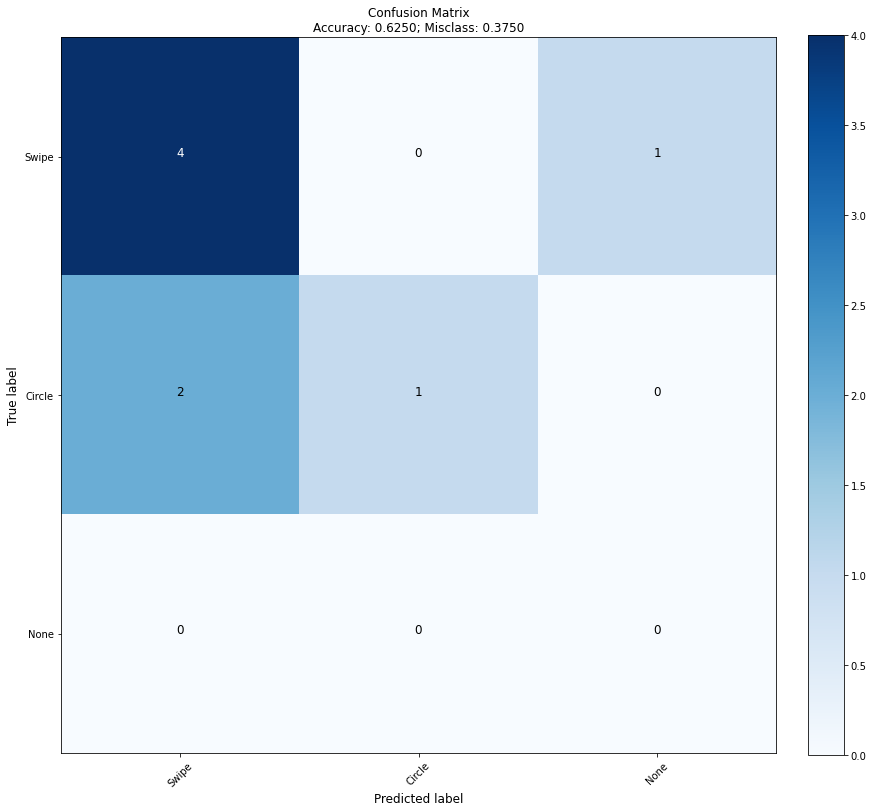

In [97]:
train_and_evaluate_model(0.40)

Number of train samples = 16
Number of test samples = 4
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.7005 - accuracy: 0.4375
Epoch 2/10
1/1 [==============================] - 0s 128ms/step - loss: 0.6911 - accuracy: 0.5625
Epoch 3/10
1/1 [==============================] - 0s 128ms/step - loss: 0.6027 - accuracy: 0.8125
Epoch 4/10
1/1 [==============================] - 0s 133ms/step - loss: 0.5286 - accuracy: 0.8125
Epoch 5/10
1/1 [==============================] - 0s 161ms/step - loss: 0.3426 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 153ms/step - loss: 0.0277 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 158ms/step - loss: 1.8456e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 130ms/step - loss: 9.4622e-07 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 718

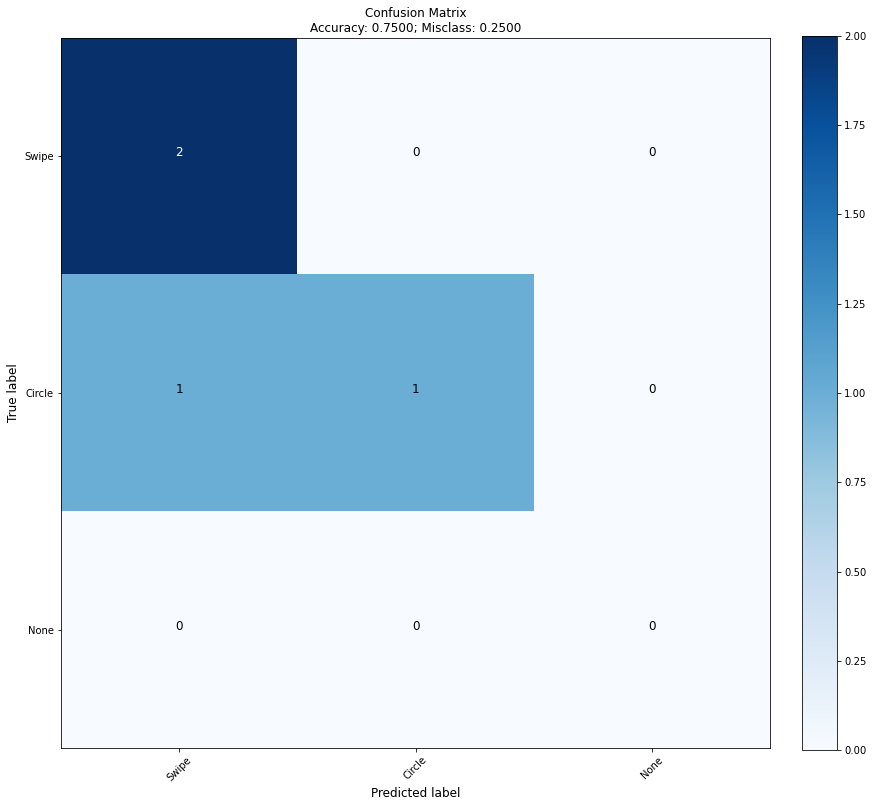

In [83]:
train_and_evaluate_model(0.20)

### Analysis
After running the data and changing the amount of data set that is used for training, and that for testing we can conclude, that when the data is trained on more data that it can better predict the results thus, having a higher match rate. (Note: that run to run we see different match rates)

- **Exercise 2** (3 marks): Consider two different numbers of the LSTM layers. Perform the classifier evaluation and compare your two choices of the layers' numbers.

Number of train samples = 16
Number of test samples = 4
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6941 - accuracy: 0.3125
Epoch 2/10
1/1 [==============================] - 0s 136ms/step - loss: 0.6695 - accuracy: 0.6875
Epoch 3/10
1/1 [==============================] - 0s 145ms/step - loss: 0.6283 - accuracy: 0.6250
Epoch 4/10
1/1 [==============================] - 0s 133ms/step - loss: 0.5182 - accuracy: 0.8125
Epoch 5/10
1/1 [==============================] - 0s 127ms/step - loss: 0.2488 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 138ms/step - loss: 0.0456 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 147ms/step - loss: 9.5303e-04 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 140ms/step - loss: 0.8984 - accuracy: 0.9375
Epoch 9/10
1/1 [==============================] - 0s 132ms/step - loss: 3.5342 - accuracy: 0.6875
Epoch 10/10
1/1 [==============================] - 1s 1s/step

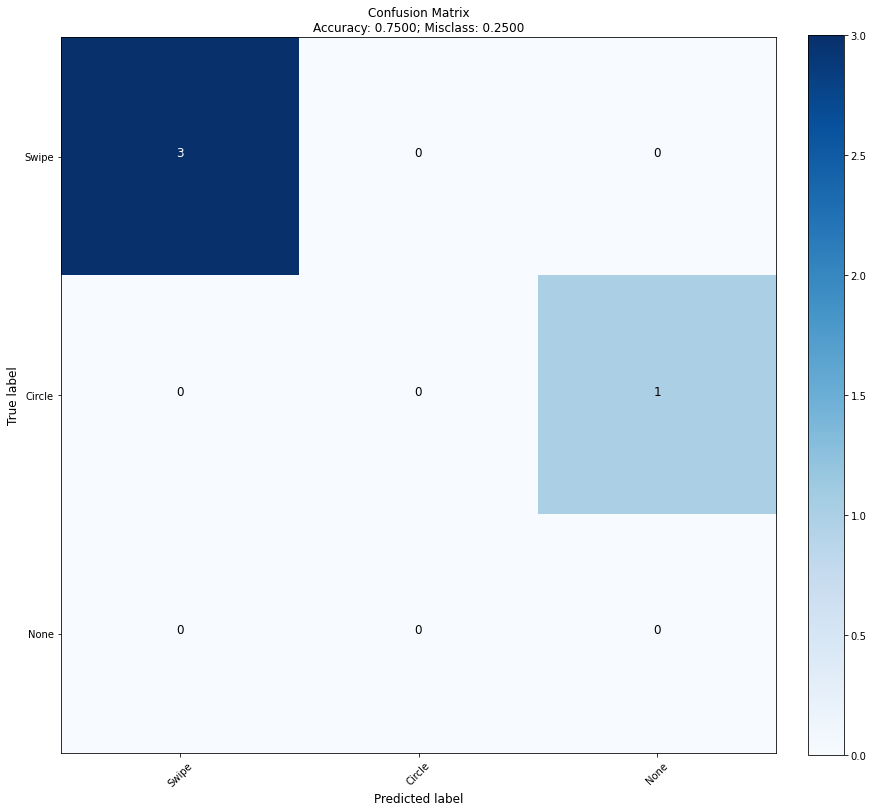

In [93]:
train_and_evaluate_model(0.2, three_ltsm_layers=False) 

Number of train samples = 16
Number of test samples = 4
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6959 - accuracy: 0.4375
Epoch 2/10
1/1 [==============================] - 0s 189ms/step - loss: 0.6780 - accuracy: 0.5625
Epoch 3/10
1/1 [==============================] - 0s 190ms/step - loss: 0.6610 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 186ms/step - loss: 0.6216 - accuracy: 0.6875
Epoch 5/10
1/1 [==============================] - 0s 193ms/step - loss: 0.4459 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 191ms/step - loss: 0.0598 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 203ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 182ms/step - loss: 1.2549e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 194ms/step - loss: 1.1183e-05 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 1s/

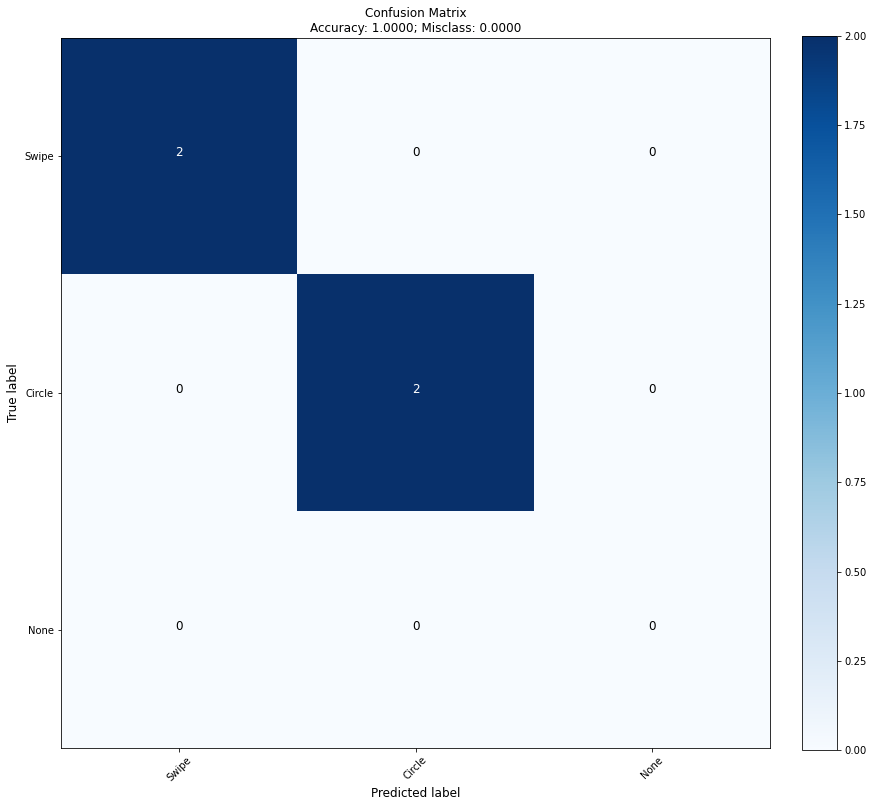

In [94]:
train_and_evaluate_model(0.2, three_ltsm_layers=True)

### Analysis
After running the data multiple times, as results vary from run to run we can conclude that adding more layers can be more beneficial in increasing model predicting power as more features are extracted thus this chould lead to a more accurate match rate. We did not observe the increase all the time here as we don't have enough data to make signficant conclusions. 

- **Exercise 3** (3 marks): Consider the dropout probability. In the code, it is set to 0.5. Change it to another value. Perform the classifier evaluation and compare it against the first case (60 and 40%).

Number of train samples = 12
Number of test samples = 8
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6924 - accuracy: 0.4167
Epoch 2/10
1/1 [==============================] - 0s 127ms/step - loss: 0.6600 - accuracy: 0.5833
Epoch 3/10
1/1 [==============================] - 0s 127ms/step - loss: 0.5916 - accuracy: 0.8333
Epoch 4/10
1/1 [==============================] - 0s 122ms/step - loss: 0.5481 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 121ms/step - loss: 0.3891 - accuracy: 0.8333
Epoch 6/10
1/1 [==============================] - 0s 124ms/step - loss: 0.1840 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 122ms/step - loss: 0.0135 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 129ms/step - loss: 2.3134e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 125ms/step - loss: 5.0664e-07 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 743

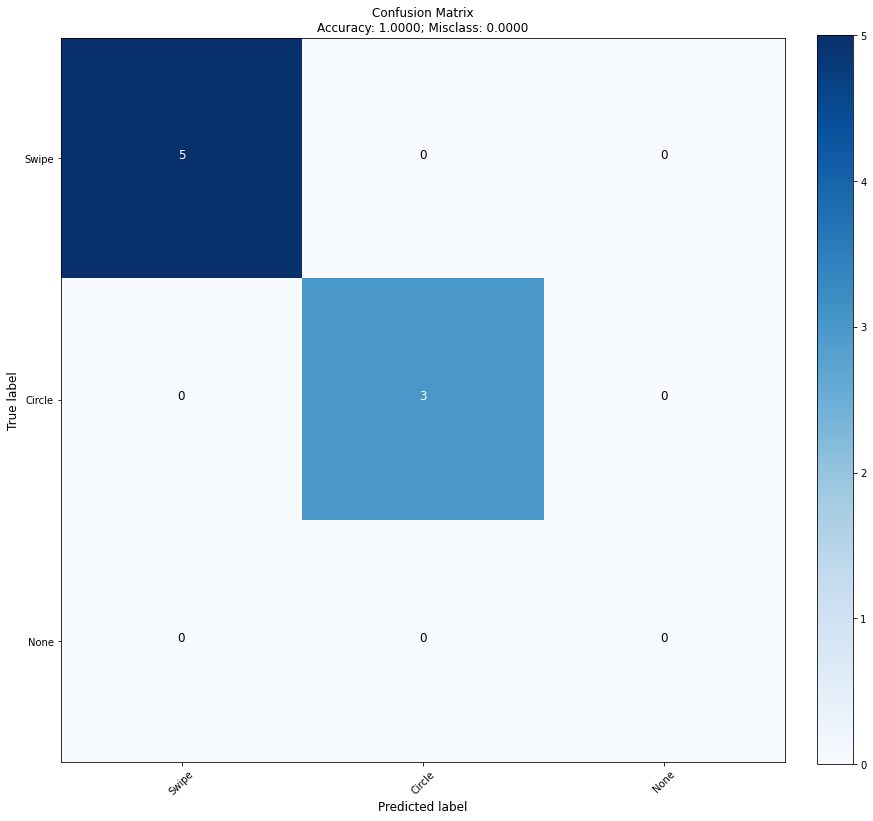

In [92]:
train_and_evaluate_model(0.4, drop_out_probability = 0.5) 

Number of train samples = 12
Number of test samples = 8
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.7002 - accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 151ms/step - loss: 0.6421 - accuracy: 0.5833
Epoch 3/10
1/1 [==============================] - 0s 121ms/step - loss: 0.5125 - accuracy: 0.8333
Epoch 4/10
1/1 [==============================] - 0s 118ms/step - loss: 0.3109 - accuracy: 0.9167
Epoch 5/10
1/1 [==============================] - 0s 117ms/step - loss: 0.1434 - accuracy: 0.9167
Epoch 6/10
1/1 [==============================] - 0s 123ms/step - loss: 3.0405e-04 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 125ms/step - loss: 2.8908e-06 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 131ms/step - loss: 1.7782e-06 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 125ms/step - loss: 4.6831 - accuracy: 0.8333
Epoch 10/10
1/1 [==============================] - 1s

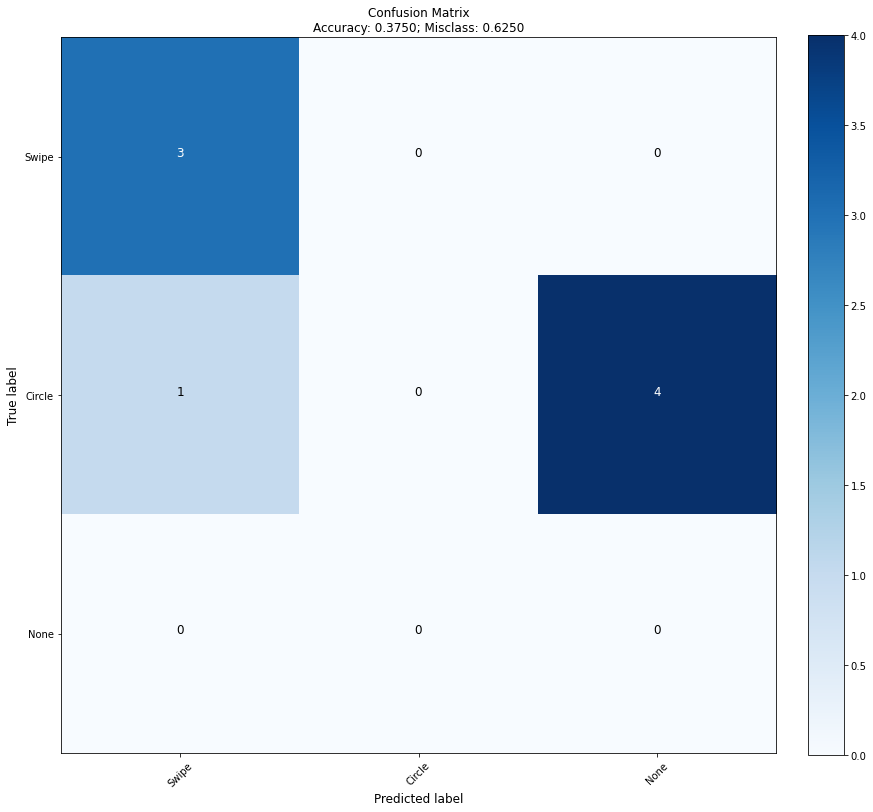

In [90]:
train_and_evaluate_model(0.4, drop_out_probability = 0.25) 

### Analysis
Again since the we do not have a lot of data we had to run this subset multiple times. The conclusions that we could make is that increased drop rate might help with stopping overfitting of the model which could help lead to more accurate matching results.

## Conclusion
In conclusion this lab was very interesting to perform and a lot of machine learning concepts were explored. We learned that increasing the data training count can lead to better matching results, that increasing the number of Long Short-term Memory (LTSM) layers can also lead to better matching results, and finally we learned that dropping some nodes can again also increase accuracy. The thing to note in this lab was a lot of these effects were *can* increase rather than will as we could not make concrete conclusions as the data set was too small and would lead to run to run differences, however, running the data multiple times did allow for some conclusions to be made.